# Introduction to Ensembling/Stacking in Python

2021 - 01 -22

참고 - [Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

# 1회차 

# Introduction

이 노트북은 기본 학습 모델, 특히 Stacking으로 알려진 앙상블의 변형 모델을 결합하는 방법에 대한 기본적인 입문서입니다. 간단한 스택 쌓기에서 몇 가지 기본 분류기의 예측과 두 번째 수준의 다른 모형을 사용하여 이전 첫 번째 수준 예측의 출력을 예측합니다.

In [205]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# Feature Exploration, Engineering and Cleaning 

먼저 데이터를 탐색하고 가능한 피처 엔지니어링을 식별하며 범주형 피처를 수치형으로 인코딩하겠습니다.

In [206]:
 # Load in the train and test datasets
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [207]:
full_data =[train, test]

# 이름 길이에 대한 피처 추가
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# 타이타닉호에서 선실을 가지고 있는 승객에 대한 피처 추가
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# SibSp 와 Parch을 합친 FamilySize 피처 추가
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# FamilySize 피처에서 IsAlone 피처 추가
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1
    
# Embarked 칼럼의 Null 값 제거
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Fare 칼럼의 Null 값 제거 + CategoricalFare 피처 추가
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# CategoricalAge 피처 추가
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# 승객이름에서 호칭 추출하는 함수 제작
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    # 호칭이 존재하면 추출 후 반환
    if title_search:
        return title_search.group(1)
    return ""

# Title 피처 추가
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# 흔하지 않은 호칭들 'Rare' 그룹으로 통합
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    # Mapping titles
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <=14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <=31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [208]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

이제 피처를 정리하고 정보 추출및 범주열을 삭제했습니다.

피처들은 모두 숫자형입니다. 이는 머신러닝 모델에 적합한 형식입니다. 그러나 계속하기 전에 변환된 데이터셋의 간단한 상관 관계 및 분포도를 생성하여 관찰해보겠습니다.

# Visualization

In [209]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


## Pearson Correlation Heatmap

피처의 상관관계 플롯을 생성하여 한 피처가 다른 피처들과 얼마나 관련이 있는지 확인할 수 있습니다.

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

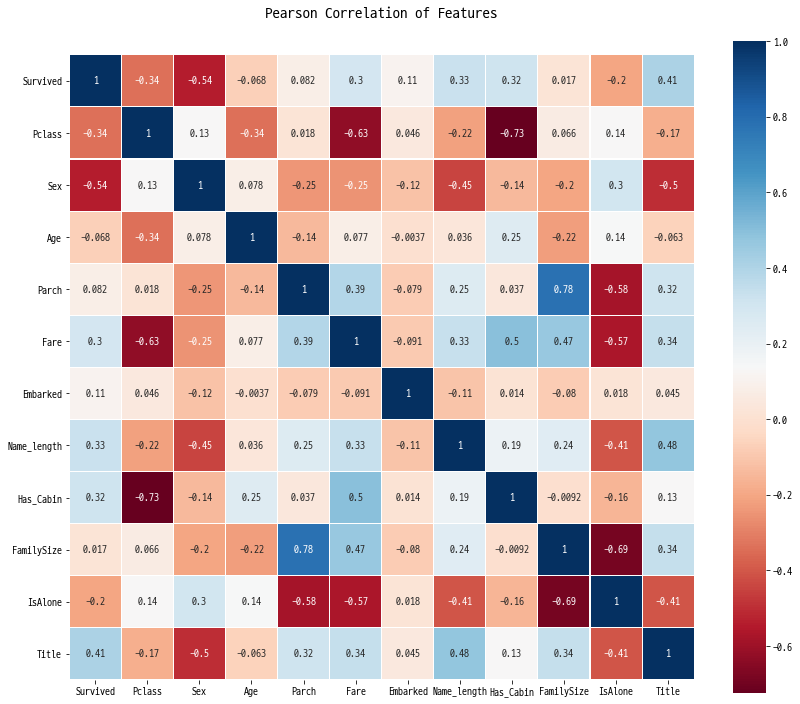

In [210]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Pearson 상관관계를 통해 알 수 있는 한 가지 사실은 서로 강한 상관 관계가 있는 피처가 그리 많지 않다는 것입니다. 이는 train set에 중복되거나 불필요한 데이터가 많지 않다는 것을 의미하며 각 기능이 고유한 정보를 제공합니다.

## Pairplots

마지막으로 pairplot을 만들어 피처 간 데이터 분포를 관찰하겠습니다.

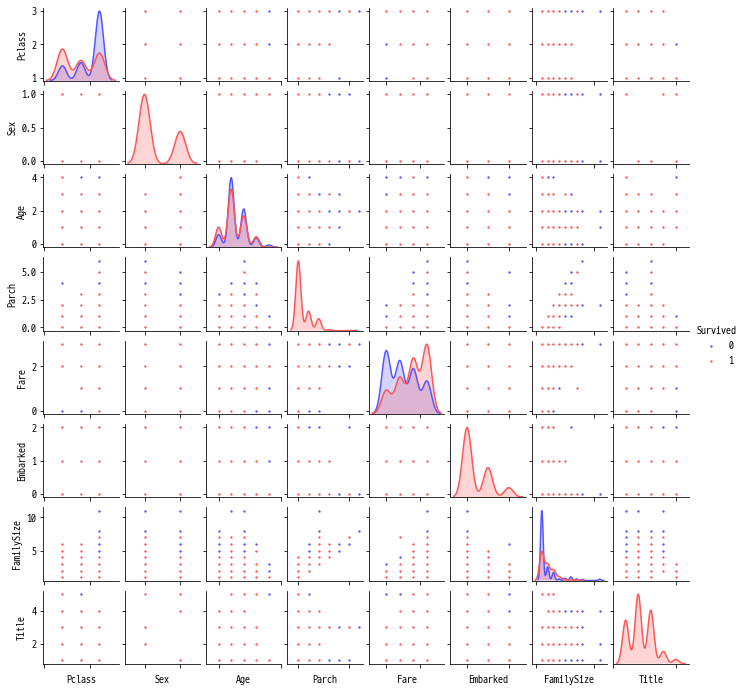

In [174]:
g = sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']], hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

# Ensembling & Stacking models

## Helpers via Python Classes

파이썬의 클래스를 사용하여 보다 편리하게 사용해봅시다. 

아래는 기본적으로 모든 Sklearn 분류기에 공통적으로 내장된 방법(예: train, test, fit)을 확장할 수 있는 클래스 SklearnHelper을 작성합니다. 따라서 5개의 다른 분류기를 호출하기 위해 동일한 방법을 5번 쓸 필요가 없으므로 중복을 줄일 수 있습니다.

In [175]:
# 나중에 쓸 몇 가지 유용한 파라미터 생성
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # 재생산성을 위한 시드 생성
NFOLDS = 5 # out-of-fold 예측을 위핸 폴드 설정
kf = KFold(n_splits = NFOLDS, random_state=SEED)

# Sklearn 분류기의 확장을 위한 클래스
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        return(self.clf.fit(x, y).feature_importances_)
    

기본 분류기를 만들 때 Sklearn 라이브러리에 이미 있는 모델만 사용하여 클래스를 확장할 것입니다.

def init: 클래스의 기본 생성자를 호출하기 위한 파이썬 표준입니다. 즉 개체(분류기)를 생성하려면 clf(원하는 sklearn 분류기), 시드(랜덤 시드) 및 매개 변수(분류기에 대한 매개 변수)를 지정해야 합니다.

나머지 코드는 단순히 sklearn 분류기 내에 존재하는 해당 메소드를 호출하는 것입니다. 기본적으로 우리는 다양한 Sklearn 분류기를 확장하기 위해 wrapper 클래스를 만들어 여러 학습자를 우리의 stacker에 구현할 때 동일한 코드를 반복해서 작성해야 하는 것을 줄일 수 있습니다.

## Out-of-Fold Predictions

스택은 기본 분류기의 예측을 2차 수준 모델에 대한 교육을 위한 입력으로 사용합니다. 그러나 단순히 전체 교육 데이터에 대한 기본 모델을 교육하고 전체 테스트셋에 대한 예측을 생성한 다음 이를 출력하여 2차 교육을 수행할 수는 없습니다. 이렇게 하면 기본 모형 예측이 이미 검정 집합을 '본' 경우 이러한 예측을 제공할 때 과적합의 위험이 있습니다.

In [176]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models

이제 5개의 학습 모델을 1단계 분류로 준비하겠습니다. 이러한 모델은 모두 Sklearn 라이브러리를 통해 호출할 수 있으며 다음과 같이 나열되어 있습니다.
1. Random Forest clasifier
2. Extra Trees clasifier
3. AdaBoost clasifier
4. Gradient Boosting clasifier
5. Support Vector Machine

## parameters

파라미터에 대한 간단한 요약입니다.

- n_jobs : 훈련 프로세스에 사용되는 코어 수입니다. -1로 설정하면 모든 코어가 사용됩니다.
- n_estimators: 학습 모델의 분류 트리 수(기본 10개)입니다.
- max_depth : 트리의 최대 깊이 또는 노드를 확장해야 하는 양입니다. 너무 높게 설정하면 트리를 너무 깊게 자르기 때문에 과적합의 위험이 있습니다.
- verbose : 학습 프로세스 중에 텍스트를 출력할 지 여부를 제어합니다. 값이 0이면 모든 텍스트가 억제되고 값이 3이면 반복할 때마다 트리 학습 프로세스가 출력됩니다.

In [177]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters
svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

OOP 프레임워크 내에서 Objects 및 클래스에 대해 언급했으므로, 앞에서 정의한 Helper Sklearn Class를 통해 5가지 학습 모델을 나타내는 개체를 생성해 보겠습니다.

In [178]:
# 4 모델을 나타내는 5 객체 생성
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

## Creating Numpy arrays out of our train and test sets

첫번째 베이스 모델을 준비했습니다. 이제 원래 데이터프레임에서 numpy array을 생성해 분류기에 입력할 수 있는 훈련 및 검증 데이터를 준비합니다.

In [179]:
# 모델에 입력할 train, test, target 데이터프레임을 numpy array로 생성
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

## Output of the First level Predictions
이제 훈련 및 검증 데이터를 5가지 기본 분류기에 입력하고 앞에서 정의한 out-of-fold 예측 기능을 사용하여 첫 번째 예측을 생성합니다.

In [180]:
# OOF train, test 예측 생성. 이를 기반으로 새로운 피처 생성 예정
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print('Training is complete')

Training is complete


첫 번째 레벨의 분류기가 학습했으므로 Sklearn 모델의 매우 미세한 기능을 활용할 수 있습니다. 즉 한 줄의 코드로 훈련 및 검증 세트의 여러 피처의 중요성을 출력할 수 있습니다.

Sklearn 문서에 따르면 대부분의 분류기는 피처 중요도를 입력하기만 하면 피처 중요도를 반환하는 속성으로 내장되어 있습니다. 

In [191]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

In [182]:
rf_features = list(rf_feature)
et_features = list(et_feature)
ada_features = list(ada_feature)
gb_features = list(gb_feature)

plotly 패키지를 통해 쉽게 플로팅할 수 있도록 피처중요도 데이터가 들어있는 리스트에서 데이터 프레임을 생성합니다.

In [183]:
cols = train.columns.values
# 데이터프레임 생성
feature_dataframe = pd.DataFrame({'features': cols,
                                  'Random Forest feature importances': rf_features,
                                  'Extra Trees feature importances': et_features,
                                  'AdaBoost feature importances': ada_features,
                                  'Gradient Boost feature importances': gb_features
                                 })

##  Interactive feature importances via Plotly scatterplots

Plotly 패키지를 사용해 'Scatter'을 호출하여 다양한 분류기의 피처 중요도 값을 산점도를 통해 시각화 합니다.

In [184]:
# Scatter Plot - Random Forest
trace = go.Scatter(
    y=feature_dataframe['Random Forest feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter Plot - Extra Trees
trace = go.Scatter(
    y=feature_dataframe['Extra Trees feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Extra Trees Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter plot - AdaBoost
trace = go.Scatter(
    y=feature_dataframe['AdaBoost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='AdaBoost Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter plot - Grdient Boost
trace = go.Scatter(
    y=feature_dataframe['Gradient Boost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Gradient Boosting Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

이제 모든 피처 중요도의 평균을 계산하여 feature importance 데이터 프레임의 새 열로 저장하겠습니다.

In [185]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1) 
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.125032,0.119693,0.026,0.088494,0.089805
1,Sex,0.201131,0.378694,0.010,0.013617,0.150860
2,Age,0.032110,0.026605,0.012,0.051299,0.030503


## Plotly Barplot Average Feature Importances

모든 분류기에서 피처 중요도의 평균을 얻었습니다. 이제 이를 bar plot으로 그리겠습니다.

In [186]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
              x= x,
              y= y,
              width= 0.5,
              marker=dict(
                         color= feature_dataframe['mean'].values,
                         colorscale='Portland',
                         showscale=True,
                         reversescale=False,
                         ),
              opacity=0.6
              )]

layout = go.Layout(
                  autosize= True,
                  title='Barplots of Mean Features Importance',
                  hovermode='closest',
                  yaxis=dict(
                            title='Feature Importance',
                            ticklen=5,
                            gridwidth=2
                  ),
                  showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output

## First-level output as new features

분류기에서 나온 첫 번째 수준의 예측으로 다음 분류기를 훈련시키겠습니다.

In [187]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(), 'ExtraTrees': et_oof_train.ravel(), 'AdaBoost': ada_oof_train.ravel(), 'GradientBoost': gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


## Correlation Heatmap of the Second Level Training set

In [188]:
data = [go.Heatmap(z=base_predictions_train.astype(float).corr().values,
                  x=base_predictions_train.columns.values,
                  y=base_predictions_train.columns.values,
                  colorscale='Viridis',
                  showscale=True,
                  reversescale=True)]
py.iplot(data, filename='labelled-heatmap')

서로 상관없이 훈련된 모델이 더 좋은 점수를 얻을 수 있다고 합니다.

첫번째 수준의 훈련/검증 예측을 x_train 및 x_test로 연결했으므로 두 번째 학습 모델을 적합시킬 수 있습니다.

## Second level learning model via XGBoost

XGBoost을 활용하여 진행하겠습니다. 

XGBClassifier을 이용해 첫번째 수준의 train/target 데이터를 적합시키고 예측에 사용하겠습니다.

In [189]:
gbm = xgb.XGBClassifier(n_estimators=2000,
                       max_depth=4,
                       min_child_weight=2,
                       gamma=0.9,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       objective= 'binary:logistic',
                       nthread=-1,
                       scale_pos_weight=1
                       ).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[15:41:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBoost에서 사용된 매개변수를 간단히 살펴보겠습니다.
- max_depth : tree의 깊이를 설정합니다. 너무 높게 설정하면 과적합 위험이 있습니다.
- gamma : 트리의 잎 노드에서 추가 파티션을 만드는데 필요한 최소 손실 감소입니다. 크기가 클 수록 알고리즘의 보수성이 높아집니다.
- eta : 과적합을 방지하기 위해 각 부스팅 단계에서 스텝 크기 축소를 사용합니다.

# Producing the Submission file

모든 1단계 및 2단계 모델을 교육하고 적합시킨 다음, 예측 결과를 출력합니다.

In [190]:
# 제출 파일 생성
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
StackingSubmission.to_csv('StackingSubmission.csv', index=False)

# 2회차

# Introduction

이 노트북은 기본 학습 모델, 특히 Stacking으로 알려진 앙상블의 변형 모델을 결합하는 방법에 대한 기본적인 입문서입니다. 간단한 스택 쌓기에서 몇 가지 기본 분류기의 예측과 두 번째 수준의 다른 모형을 사용하여 이전 첫 번째 수준 예측의 출력을 예측합니다.

In [211]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# Feature Exploration, Engineering and Cleaning

 먼저 데이터를 탐색하고 가능한 피처 엔지니어링을 식별하며 범주형 피처를 수치형으로 인코딩하겠습니다.

In [212]:
# Load in the train and test datasets
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [213]:
full_data = [train, test]

# 이름 피처 추가
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# 선실을 가진 승객 피처 추가
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# FamilySize 피처 추가
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# IsAlone 피처 추가
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1

# Embarked 결측치 제거
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Fare 결측치 제거 + CategoricalFare 피처 추가
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# CategoricalAge 피처 추가
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# 호칭 추출 함수
def get_title(name):
    title_search = re.search('([A-Za-z]_+)\.', name)
    # 호칭 존재시 추출
    if title_search:
        return title_search.group(1)
    return ""

# Title 피처 추가
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Rare 그룹 추가
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    
    # Mapping titles
    title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare']=1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']=2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [214]:
# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

이제 피처를 정리하고 정보 추출및 범주열을 삭제했습니다.

피처들은 모두 숫자형입니다. 이는 머신러닝 모델에 적합한 형식입니다. 그러나 계속하기 전에 변환된 데이터셋의 간단한 상관 관계 및 분포도를 생성하여 관찰해보겠습니다.

# Visualization

In [215]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,0.0
1,1,1,0,2,0,3,1,51,1,2,0,0.0
2,1,3,0,1,0,1,0,22,0,1,1,0.0
3,1,1,0,2,0,3,0,44,1,2,0,0.0
4,0,3,1,2,0,1,0,24,0,1,1,0.0


## Pearson Correlation Heatmap

피처의 상관관계 플롯을 생성하여 한 피처가 다른 피처들과 얼마나 관련이 있는지 확인할 수 있습니다.

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

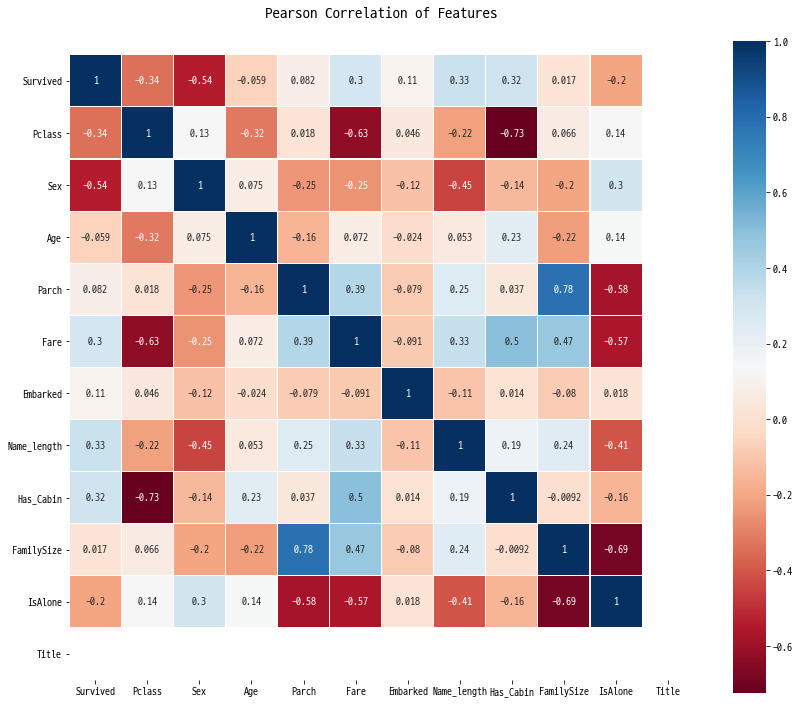

In [217]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Pearson 상관관계를 통해 알 수 있는 한 가지 사실은 서로 강한 상관 관계가 있는 피처가 그리 많지 않다는 것입니다. 이는 train set에 중복되거나 불필요한 데이터가 많지 않다는 것을 의미하며 각 기능이 고유한 정보를 제공합니다.

## Pairplots

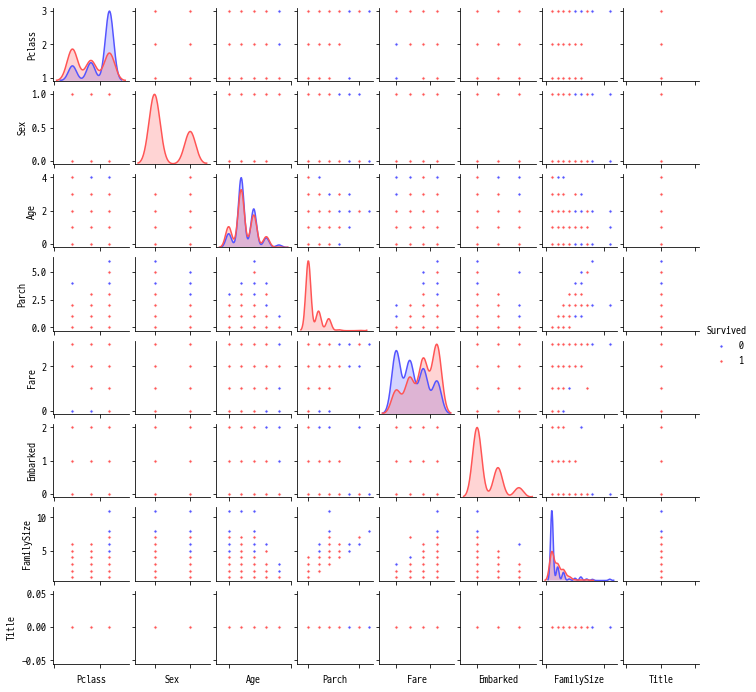

In [218]:
g = sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']], hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

# Ensembling & Stacking models

## Helpers via Python Classes

파이썬의 클래스를 사용하여 보다 편리하게 사용해봅시다.

아래는 기본적으로 모든 Sklearn 분류기에 공통적으로 내장된 방법(예: train, test, fit)을 확장할 수 있는 클래스 SklearnHelper을 작성합니다. 따라서 5개의 다른 분류기를 호출하기 위해 동일한 방법을 5번 쓸 필요가 없으므로 중복을 줄일 수 있습니다.

In [220]:
# 나중에 쓸 몇 가지 유용한 파라미터 생성
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits= NFOLDS, random_state=SEED)

# Sklearn 분류기의 확장을 위한 클래스
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        return(self.clf.fit(x, y).feature_importances_)

기본 분류기를 만들 때 Sklearn 라이브러리에 이미 있는 모델만 사용하여 클래스를 확장할 것입니다.

def init: 클래스의 기본 생성자를 호출하기 위한 파이썬 표준입니다. 즉 개체(분류기)를 생성하려면 clf(원하는 sklearn 분류기), 시드(랜덤 시드) 및 매개 변수(분류기에 대한 매개 변수)를 지정해야 합니다.

나머지 코드는 단순히 sklearn 분류기 내에 존재하는 해당 메소드를 호출하는 것입니다. 기본적으로 우리는 다양한 Sklearn 분류기를 확장하기 위해 wrapper 클래스를 만들어 여러 학습자를 우리의 stacker에 구현할 때 동일한 코드를 반복해서 작성해야 하는 것을 줄일 수 있습니다.

## Out-of-Fold Predictions

스택은 기본 분류기의 예측을 2차 수준 모델에 대한 교육을 위한 입력으로 사용합니다. 그러나 단순히 전체 교육 데이터에 대한 기본 모델을 교육하고 전체 테스트셋에 대한 예측을 생성한 다음 이를 출력하여 2차 교육을 수행할 수는 없습니다. 

이렇게 하면 기본 모형 예측이 이미 검정 집합을 '본' 경우 이러한 예측을 제공할 때 과적합의 위험이 있습니다.

In [226]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models

이제 5개의 학습 모델을 1단계 분류로 준비하겠습니다. 이러한 모델은 모두 Sklearn 라이브러리를 통해 호출할 수 있으며 다음과 같이 나열되어 있습니다.
1. Random Forest clasifier
2. Extra Trees clasifier
3. AdaBoost clasifier
4. Gradient Boosting clasifier
5. Support Vector Machine

### parameters

파라미터에 대한 간단한 요약입니다.

- n_jobs : 훈련 프로세스에 사용되는 코어 수입니다. -1로 설정하면 모든 코어가 사용됩니다.
- n_estimators: 학습 모델의 분류 트리 수(기본 10개)입니다.
- max_depth : 트리의 최대 깊이 또는 노드를 확장해야 하는 양입니다. 너무 높게 설정하면 트리를 너무 깊게 자르기 때문에 과적합의 위험이 있습니다.
- verbose : 학습 프로세스 중에 텍스트를 출력할 지 여부를 제어합니다. 값이 0이면 모든 텍스트가 억제되고 값이 3이면 반복할 때마다 트리 학습 프로세스가 출력됩니다.

In [222]:
# Random Forest parameters
rf_params= {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees parameters
et_params= {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params= {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# Gradient Boosting parameters
gb_params= {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters
svc_params= {
    'kernel': 'linear',
    'C': 0.025
}

OOP 프레임워크 내에서 Objects 및 클래스에 대해 언급했으므로, 앞에서 정의한 Helper Sklearn Class를 통해 5가지 학습 모델을 나타내는 개체를 생성해 보겠습니다.

In [223]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating Numpy arrays out of our train and test sets
첫번째 베이스 모델을 준비했습니다. 이제 원래 데이터프레임에서 numpy array을 생성해 분류기에 입력할 수 있는 훈련 및 검증 데이터를 준비합니다.

In [224]:
# 모델에 입력할 train, test, target 데이터프레임을 np array로 생성
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

### Output of the First level Predictions
이제 훈련 및 검증 데이터를 5가지 기본 분류기에 입력하고 앞에서 정의한 out-of-fold 예측 기능을 사용하여 첫 번째 예측을 생성합니다.

In [227]:
# OOF train, test 예측 생성
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print('Training is complete')

Training is complete


첫 번째 레벨의 분류기가 학습했으므로 Sklearn 모델의 매우 미세한 기능을 활용할 수 있습니다. 즉 한 줄의 코드로 훈련 및 검증 세트의 여러 피처의 중요성을 출력할 수 있습니다.

Sklearn 문서에 따르면 대부분의 분류기는 피처 중요도를 입력하기만 하면 피처 중요도를 반환하는 속성으로 내장되어 있습니다.

In [228]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

In [229]:
rf_features = list(rf_feature)
et_features = list(et_feature)
ada_features = list(ada_feature)
gb_features = list(gb_feature)

plotly 패키지를 통해 쉽게 플로팅할 수 있도록 피처중요도 데이터가 들어있는 리스트에서 데이터 프레임을 생성합니다.

In [235]:
cols = train.columns.values
# 데이터프레임 생성
feature_dataframe = pd.DataFrame({'features': cols, 'Random Forest feature importances': rf_features, 'Extra Trees feature importances': et_features, 'AdaBoost feature importances': ada_features, 'Gradient Boost feature importances': gb_features})

## Interactive feature importances via Plotly scatterplots
Plotly 패키지를 사용해 'Scatter'을 호출하여 다양한 분류기의 피처 중요도 값을 산점도를 통해 시각화 합니다.

In [236]:
# Random Forest
trace = go.Scatter(y=feature_dataframe['Random Forest feature importances'].values,
                   x=feature_dataframe['features'].values,
                   mode='markers',
                   marker=dict(sizemode='diameter',
                               sizeref=1,
                               size=25,
                               color=feature_dataframe['Random Forest feature importances'].values,
                               colorscale='Portland',
                               showscale=True), text=feature_dataframe['features'].values)
data = [trace]

layout = go.Layout(autosize=True,
                  title='Random Forest Feature Importances',
                  hovermode='closest', 
                  yaxis=dict(title='Feature Importance',
                            ticklen=5,
                            gridwidth=2),
                  showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Extra Trees
trace = go.Scatter(y=feature_dataframe['Extra Trees feature importances'].values,
                   x=feature_dataframe['features'].values,
                   mode='markers',
                   marker=dict(sizemode='diameter',
                               sizeref=1,
                               size=25,
                               color=feature_dataframe['Extra Trees feature importances'].values,
                               colorscale='Portland',
                               showscale=True), text=feature_dataframe['features'].values)
data = [trace]

layout = go.Layout(autosize=True,
                  title='Extra Trees Feature Importances',
                  hovermode='closest', 
                  yaxis=dict(title='Feature Importance',
                            ticklen=5,
                            gridwidth=2),
                  showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# AdaBoost
trace = go.Scatter(y=feature_dataframe['AdaBoost feature importances'].values,
                   x=feature_dataframe['features'].values, mode='markers',
                   marker=dict(sizemode='diameter',
                               sizeref=1,
                               size=25,
                               color=feature_dataframe['AdaBoost feature importances'].values,
                               colorscale='Portland',
                               showscale=True), text=feature_dataframe['features'].values)
data = [trace]

layout = go.Layout(autosize=True,
                  title='AdaBoost Feature Importances',
                  hovermode='closest', 
                  yaxis=dict(title='Feature Importance',
                            ticklen=5,
                            gridwidth=2),
                  showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Gradient Boost
trace = go.Scatter(y=feature_dataframe['Gradient Boost feature importances'].values,
                   x=feature_dataframe['features'].values, mode='markers',
                   marker=dict(sizemode='diameter',
                               sizeref=1,
                               size=25,
                               color=feature_dataframe['Gradient Boost feature importances'].values,
                               colorscale='Portland',
                               showscale=True), text=feature_dataframe['features'].values)
data = [trace]

layout = go.Layout(autosize=True,
                  title='Gradient Boost Feature Importances',
                  hovermode='closest', 
                  yaxis=dict(title='Feature Importance',
                            ticklen=5,
                            gridwidth=2),
                  showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

이제 모든 피처 중요도의 평균을 계산하여 feature importance 데이터 프레임의 새 열로 저장하겠습니다

In [237]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.135019,0.135145,0.022,0.113873,0.101509
1,Sex,0.355273,0.533860,0.012,0.378000,0.319783
2,Age,0.047807,0.028727,0.022,0.066873,0.041351


## Plotly Barplot Average Feature Importances
모든 분류기에서 피처 중요도의 평균을 얻었습니다. 이제 이를 bar plot으로 그리겠습니다.

In [238]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(x= x,
              y= y,
              width= 0.5,
              marker=dict(color=feature_dataframe['mean'].values,
                         colorscale='Portland',
                         showscale=True,
                         reversescale=False
                         ),
              opacity=0.6
              )]

layout = go.Layout(autosize=True,
                  title='Barplots of Mean Features Importance',
                  hovermode='closest',
                  yaxis=dict(title='Feature Importance',
                            ticklen=5,
                            gridwidth=2
                            ),
                   showlegend=False
                  )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output


### First-level output as new features
분류기에서 나온 첫 번째 수준의 예측으로 다음 분류기를 훈련시키겠습니다.

In [239]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(), 'ExtraTrees': et_oof_train.ravel(), 'AdaBoost': ada_oof_train.ravel(), 'GradientBoost': gb_oof_train.ravel()})
base_predictions_train

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
886,0.0,0.0,0.0,0.0
887,1.0,1.0,1.0,1.0
888,0.0,0.0,0.0,0.0
889,1.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

In [240]:
data = [go.Heatmap(z=base_predictions_train.astype(float).corr().values,
                   x=base_predictions_train.columns.values,
                   y=base_predictions_train.columns.values,
                   colorscale='Viridis',
                   showscale=True,
                   reversescale=True)]
py.iplot(data, filename='labelled-heatmap')

서로 상관없이 훈련된 모델이 더 좋은 점수를 얻을 수 있다고 합니다.

첫번째 수준의 훈련/검증 예측을 x_train 및 x_test로 연결했으므로 두 번째 학습 모델을 적합시킬 수 있습니다.

### Second level learning model via XGBoost

XGBoost을 활용하여 진행하겠습니다.

XGBClassifier을 이용해 첫번째 수준의 train/target 데이터를 적합시키고 예측에 사용하겠습니다.

In [241]:
gbm = xgb.XGBClassifier(n_estimators=2000,
                       max_depth=4,
                       min_child_weight=2, 
                        gamma=0.9,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective='binary:logistic',
                        nthread=-1,
                        scale_pos_weight=1
                       ).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[19:35:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBoost에서 사용된 매개변수를 간단히 살펴보겠습니다.
- max_depth : tree의 깊이를 설정합니다. 너무 높게 설정하면 과적합 위험이 있습니다.
- gamma : 트리의 잎 노드에서 추가 파티션을 만드는데 필요한 최소 손실 감소입니다. 크기가 클 수록 알고리즘의 보수성이 높아집니다.
- eta : 과적합을 방지하기 위해 각 부스팅 단계에서 스텝 크기 축소를 사용합니다.

## Producing the Submission file

모든 1단계 및 2단계 모델을 교육하고 적합시킨 다음, 예측 결과를 출력합니다.

In [242]:
# 제출 파일 생성
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
StackingSubmission.to_csv('StackingSubmission.csv', index=False)